# Clustering plots

Reads in the data files containing the cluster data sets

In this Jupyter Notebook we preform the k-means clustering for the HYSPLIT outputs. We produce figure 4, figure S12, and figures S6. 

***Figures:***
- Figure 4
- Figure S12
- Figure S6

***Need:***

- Harmonised data set
- the rainfall data 
- the clustering data set i.e. 
- r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered\all_years_clustered_5_v2.pickle'
- 'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered\df_clusters_5_v2.pickle'

In [1]:
import sys

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\clustering_HYSPLIT')
import clustering_functions as fu_cluster

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\functions_backtrajectories')
import functions_backtrajectories as fu_backtraj

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\Trends')
import trends_functions as fu_trends

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from dateutil.relativedelta import relativedelta

%load_ext autoreload
%autoreload 2

## Deleting variables with too much memory (if required): 

In [2]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, fu_cluster.sizeof_fmt(size)))

                          tqdm:  1.0 KiB
                 relativedelta:  1.0 KiB
               NamespaceMagics:  896.0 B
                            _i:  701.0 B
                           _i1:  701.0 B
                           _i2:  263.0 B
                           _oh:  232.0 B
                           Out:  232.0 B
                   get_ipython:  136.0 B
                    _getsizeof:  136.0 B


## load data: 

In [3]:
savepathplots = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\plots'

In [4]:
df_abs637 = fu_cluster.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended', 
                    filename='oldpsap_newpsap_maap')
df_era5_GDAS = fu_trends.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall',                   
                       filename='era5_GDAS_2002_2023')

df_abs637_rain = pd.merge(df_abs637, df_era5_GDAS, left_index=True, right_index=True)

first_season = fu_trends.get_first_season(df_abs637_rain)        
season_to_season_num = fu_trends.get_full_season_abb_years(start_year=2002, number_years=2024-2002, first_season=first_season)
season_num_to_season = fu_trends.reverse_dict(season_to_season_num)

df_abs637_rain = fu_trends.prepare_data(df_abs637_rain, season_num_to_season)

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\absorption\appended\oldpsap_newpsap_maap.dat
loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\ERA5_rainfall\era5_GDAS_2002_2023.dat
start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


In [5]:
xyz_cols = fu_cluster.generate_xyz_col_names(elements_in_col_name=['x_', 'y_', 'z_'], length=241)
dict_dtype = fu_cluster.generate_dict_dtype(xyz_cols, float_type=np.float32) #6363563.0

x_
y_
z_
max for dtype: 3.4028235e+38


In [6]:
nb_clusters=5

# Load files: 

## the full file 
i.e. with all the x,y,z coordinates for the all the ensembles

In [ ]:
file = r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered\all_years_clustered_5_v2.pickle'
df_clustering = pd.read_pickle(file)
df_clustering = df_clustering.astype(dict_dtype)   

## only clusters: 

i.e. timesteps, ensemble number and cluster: 

In [ ]:
df_clusters = pd.read_pickle(r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\clustered\df_clusters_5_v2.pickle')
df_clusters = df_clusters.reset_index()
df_clusters = df_clusters.set_index('arrival_time')

In [ ]:
df_clusters.head(2)

### or If you have the full timseries - you have to select hourly clusters: 

In [ ]:
if df_clustering is not None:
    df_clusters = df_clustering['clusters_'+str(nb_clusters)]
    df_clusters = df_clusters.reset_index()
    df_clusters = df_clusters.set_index('arrival_time')

In [ ]:
df_clusters.head(2)

## Count: 

In [ ]:
df_value_count = fu_cluster.count_value_find_percentage(df_clusters, nb_clusters=nb_clusters)

In [ ]:
df_value_count.head(2)

## Assign based on 0.5 rule: 

In [ ]:
def thickax(ax):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
        ax.spines[axis].set_color('k')
    plt.rc('axes', linewidth=0.2)
    fontsize = 12
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=8, width=1.3, pad=10, bottom=True, top=False, left=True, right=False, color='k')
    ax.tick_params(which='minor', length=4, color='k', width=1.3)

def plot_distribution_of_cluster_counts(df_value_count):
    df_max_proportion = df_value_count.groupby('arrival_time').agg({'count':'max'})
    x = df_max_proportion.values
    for majority_per in np.arange(.5, 1., .1):
        percentage = len(x[x > majority_per])/len(x)
        print()
    fig = sns.displot(x, alpha=.5, legend=False, height=5., color='k', aspect=2, palette=["black"])
    plt.axvline(x=0.5, c='r', ls=':', alpha=.5)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.ylabel('Count [-]', fontsize=20)
    plt.xlabel('Max fraction of the contributing clusters', fontsize=20)
    plt.rc('axes', linewidth=2,)
    plt.show()
    return fig

# Figure: S6: 

In [ ]:
fig = plot_distribution_of_cluster_counts(df_value_count)
fu_cluster.save_plot(fig, path=savepathplots, folder='', 
              name='FigureS6', formated=".png", dpi=300)

# Now the representative clusters have been found (for each observation/hour): 

In [ ]:
df_max_count = fu_cluster.find_the_max_count(df_value_count)
df_max_count_abs637 = fu_cluster.merge_with_obs(df_max_count, df_abs637_rain)

In [ ]:
df_max_count_abs637.head(2)

## Percentages: 

### absorption dictionary: 

In [ ]:
df_percentage_clusters_abs = fu_cluster.calculate_percentage_of_clusters_and_averages(df_max_count_abs637, 
                                                                     nb_clusters=nb_clusters, var='abs637')
dict_var_to_df_values = {'abs637':df_percentage_clusters_abs} 

### precipitation dictionary: 

In [ ]:
df_percentage_clusters_rain = fu_cluster.calculate_percentage_of_clusters_and_averages(df_max_count_abs637, 
                                                                     nb_clusters=nb_clusters, var='tp_era5')
dict_var_to_df_values['accumulated'] = df_percentage_clusters_rain #store in dictionary

# Find mean cluster: 

In [ ]:
df_clustering.head(2)

## get a dictionary for the cluster and the mean trajectory of that cluster - this is done for all clusters

uses a lot of memory

In [ ]:
dict_cluster_to_df_mean = fu_cluster.create_dict_cluster_to_df_average(df_clustering, nb_clusters=nb_clusters)

In [ ]:
dict_cluster_to_df_median = fu_cluster.create_dict_cluster_to_df_average(df_clustering, nb_clusters=nb_clusters,
                                                                        mean=False, median=True)

find the endpoint of the cluster means

In [ ]:
dict_cluster_to_endpoint_lon = {}
for cluster, df_mean_traj_for_cluster in dict_cluster_to_df_mean.items():
    print(cluster)
    endpoint_lon = df_mean_traj_for_cluster['lon'].iloc[-1] #find the endpoint of the avergae
    print(endpoint_lon)
    dict_cluster_to_endpoint_lon[cluster] = endpoint_lon

save the mean clusters: 

In [ ]:
for cluster, df_mean_traj_for_cluster in dict_cluster_to_df_mean.items():
    fu_cluster.save_df(df_mean_traj_for_cluster, r'F:\HYSPLIT\processed\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters', 
            name='df_mean_traj_cluster_'+str(cluster))

## load average trajectories: 

In [58]:
dict_cluster_to_df_mean = {} 
for cluster in [1,2,3,4,5]:
    df_mean_traj_for_cluster = pd.read_csv(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Clustering\ensembles_for_clustering\xyz_rotated\mean_trajs_clusters\df_mean_traj_cluster_'+str(cluster)+'.dat',
                                          index_col=0)
    dict_cluster_to_df_mean[cluster] = df_mean_traj_for_cluster 

# Plot mean trajectories of clusters: 

## decide on a colour bar that has 5 distinct colourblind friendly colours

{1: array([0.5, 0. , 1. , 1. ]), 2: array([0.00196078, 0.70928131, 0.92328911, 1.        ]), 3: array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 4: array([1.        , 0.70054304, 0.37841105, 1.        ]), 5: array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])}


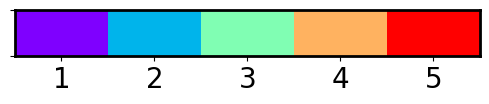

In [37]:
cmap='rainbow'
dict_cluster_to_colors = fu_cluster.create_dict_cluster_to_colours(nb_clusters=nb_clusters,
                                                                  cmap=cmap)
fu_cluster.view_colormap(cmap, number_of_colours=nb_clusters)

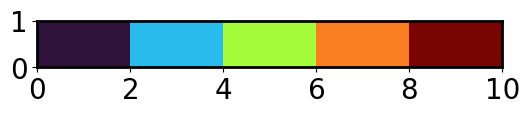

In [38]:
cmap='turbo'
number_of_colours = 5

fig, ax = plt.subplots(1, figsize=(6, 2),)
colors=plt.get_cmap(cmap)(np.linspace(0,1, int(number_of_colours)))
ax.imshow([colors], extent=[0, 10, 0, 1]) 
plt.show()

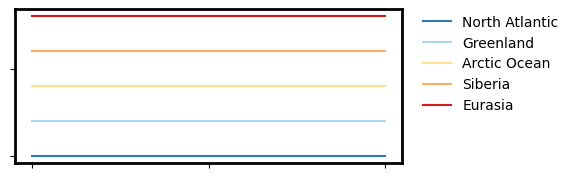

In [40]:
colors = ['#2c7bb6', '#abd9e9','#fee090','#fdae61','#d7191c']

clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

fig, ax = plt.subplots(figsize=(5, 2))
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, label=names[i])
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), borderaxespad=0)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [41]:
dict_cluster_to_colors = dict(zip(np.arange(1,6,1), colors))

# Map plots: 

plot the mean trajectory
create colour map dict


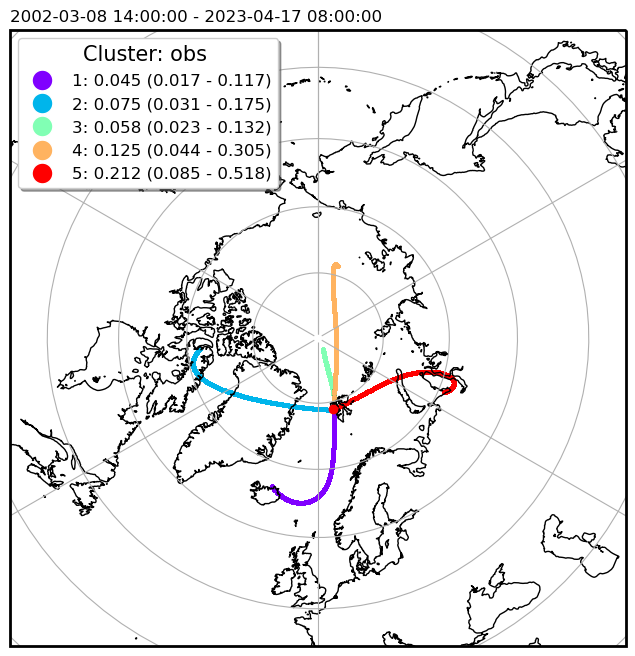

In [60]:
fig = fu_cluster.plot_trajs_clusters(df_clusters, dict_cluster_to_df_mean,
                                     5, axes_projection='North_Stereo', 
                                     scatter_projection='rotated_pole', 
                                     df_values=dict_var_to_df_values['abs637'],
                                     )

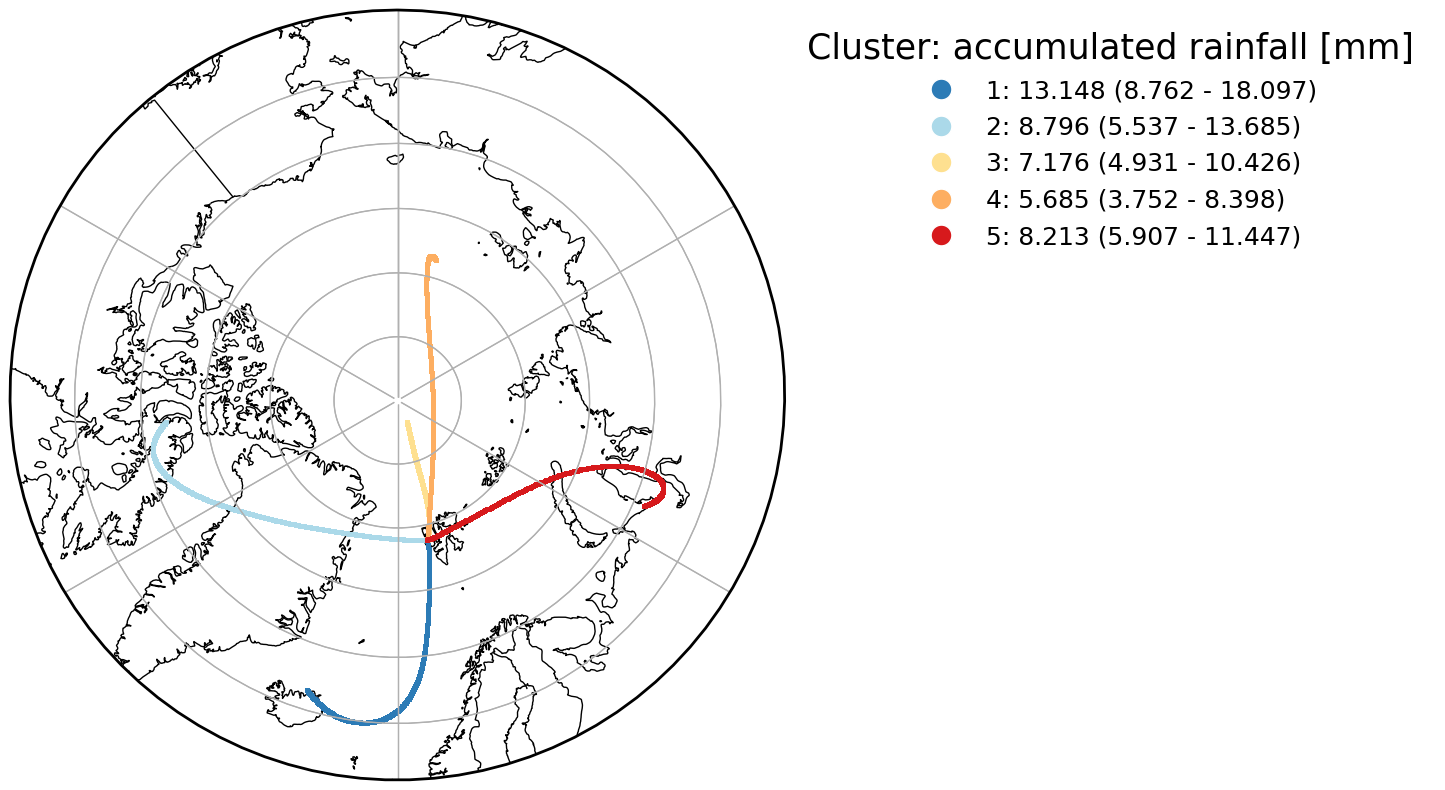

In [61]:
fig = fu_cluster.circular_plots(5, dict_cluster_to_df_mean, 
                               df_values=dict_var_to_df_values['accumulated'],
                               title = "Cluster: accumulated rainfall [mm] ",  
                               dict_cluster_to_colors=dict_cluster_to_colors)

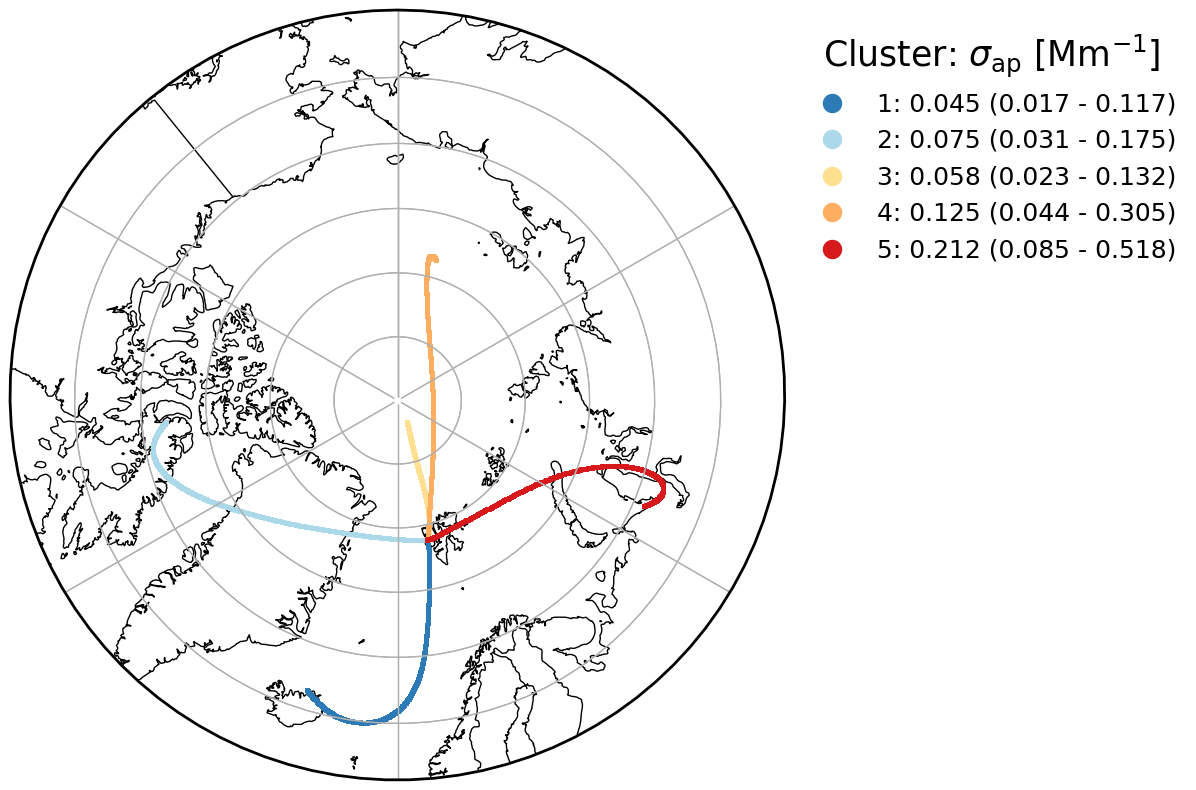

In [62]:
fig = fu_cluster.circular_plots(5, dict_cluster_to_df_mean, 
                                df_values=dict_var_to_df_values['abs637'],
                                title="Cluster: $\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]",
                                dict_cluster_to_colors=dict_cluster_to_colors)

#  Frequency plots of clusters per month: 

5
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


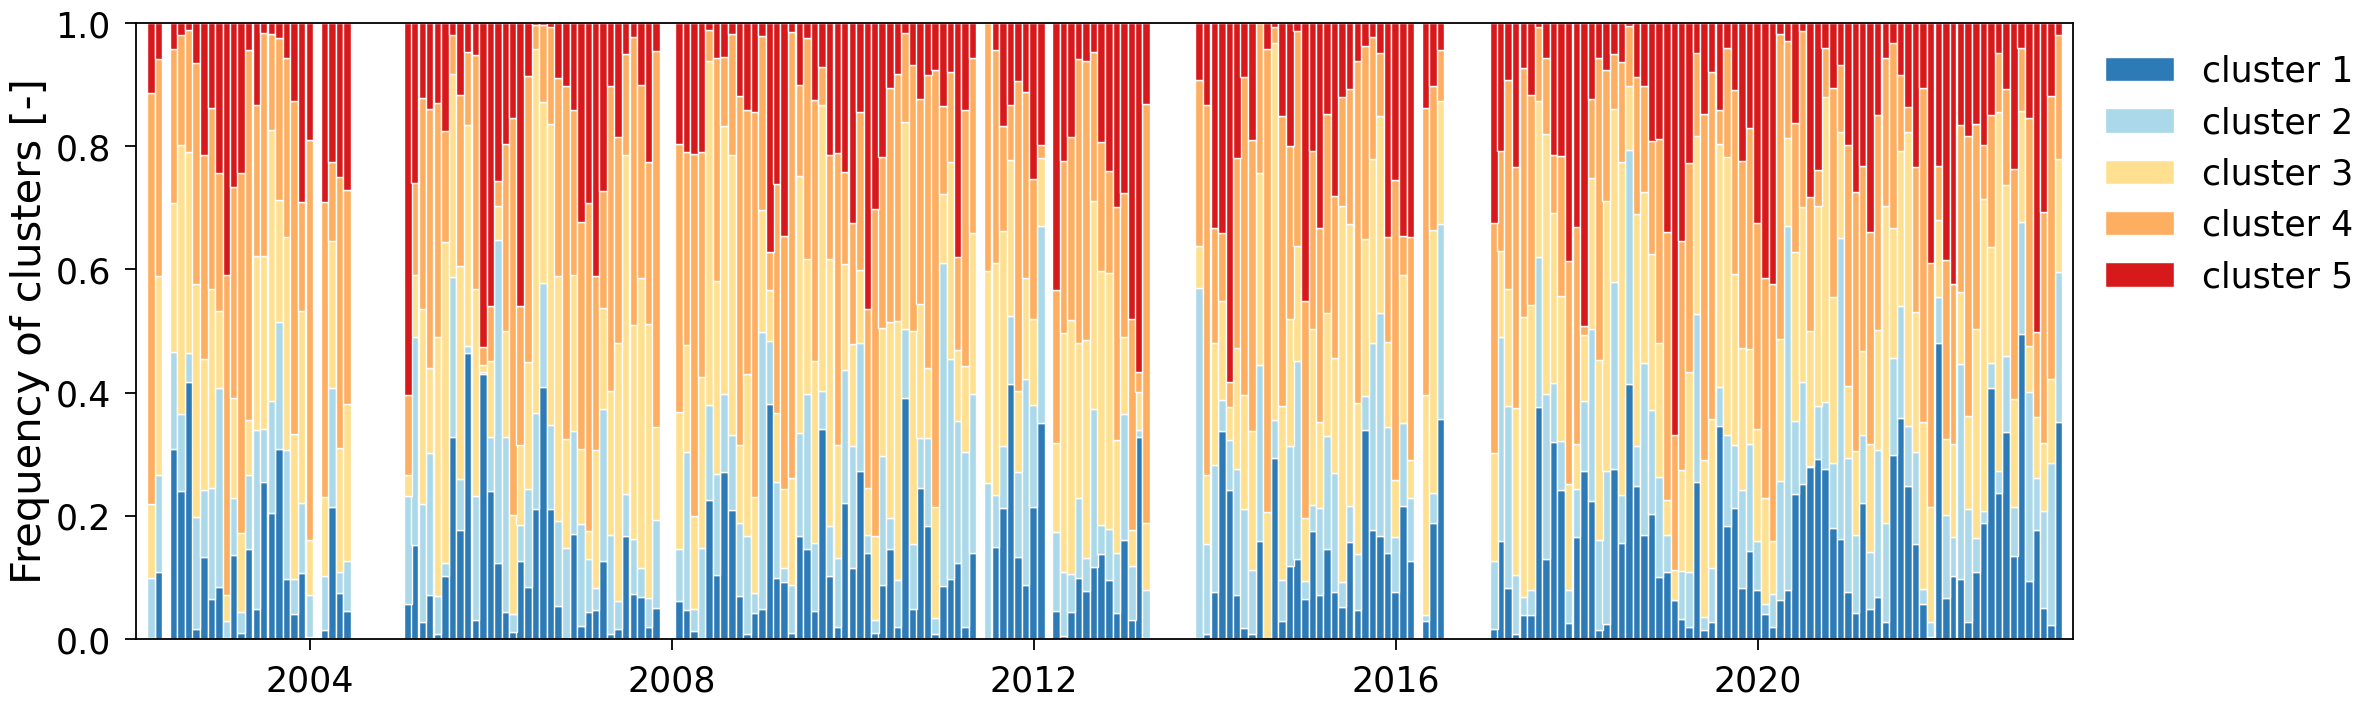

In [63]:
df_month_years_clusters = fu_cluster.month_years_clusters(df_clusters, nb_clusters=5)
month_year_ticks = fu_cluster.create_ticks_months_years(df_month_years_clusters)

fig = fu_cluster.plot_all_month_and_clusters(df_month_years_clusters, nb_clusters=5, 
                                             dict_cluster_to_colors=dict_cluster_to_colors,
                                             days_to_subtract_xlim=60)

In [65]:
df_max_count_abs637.head(2)

,clusters_5,count,abs637,fraction_241,tp_era5,RAINFALL,date,timestamp,ordinal,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,5,0.555556,0.238,1.0,6.328704,3.969907,2002-03-08,2002-03-08 14:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,5,0.555556,0.082,1.0,6.259259,3.277778,2002-03-08,2002-03-08 15:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


5
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


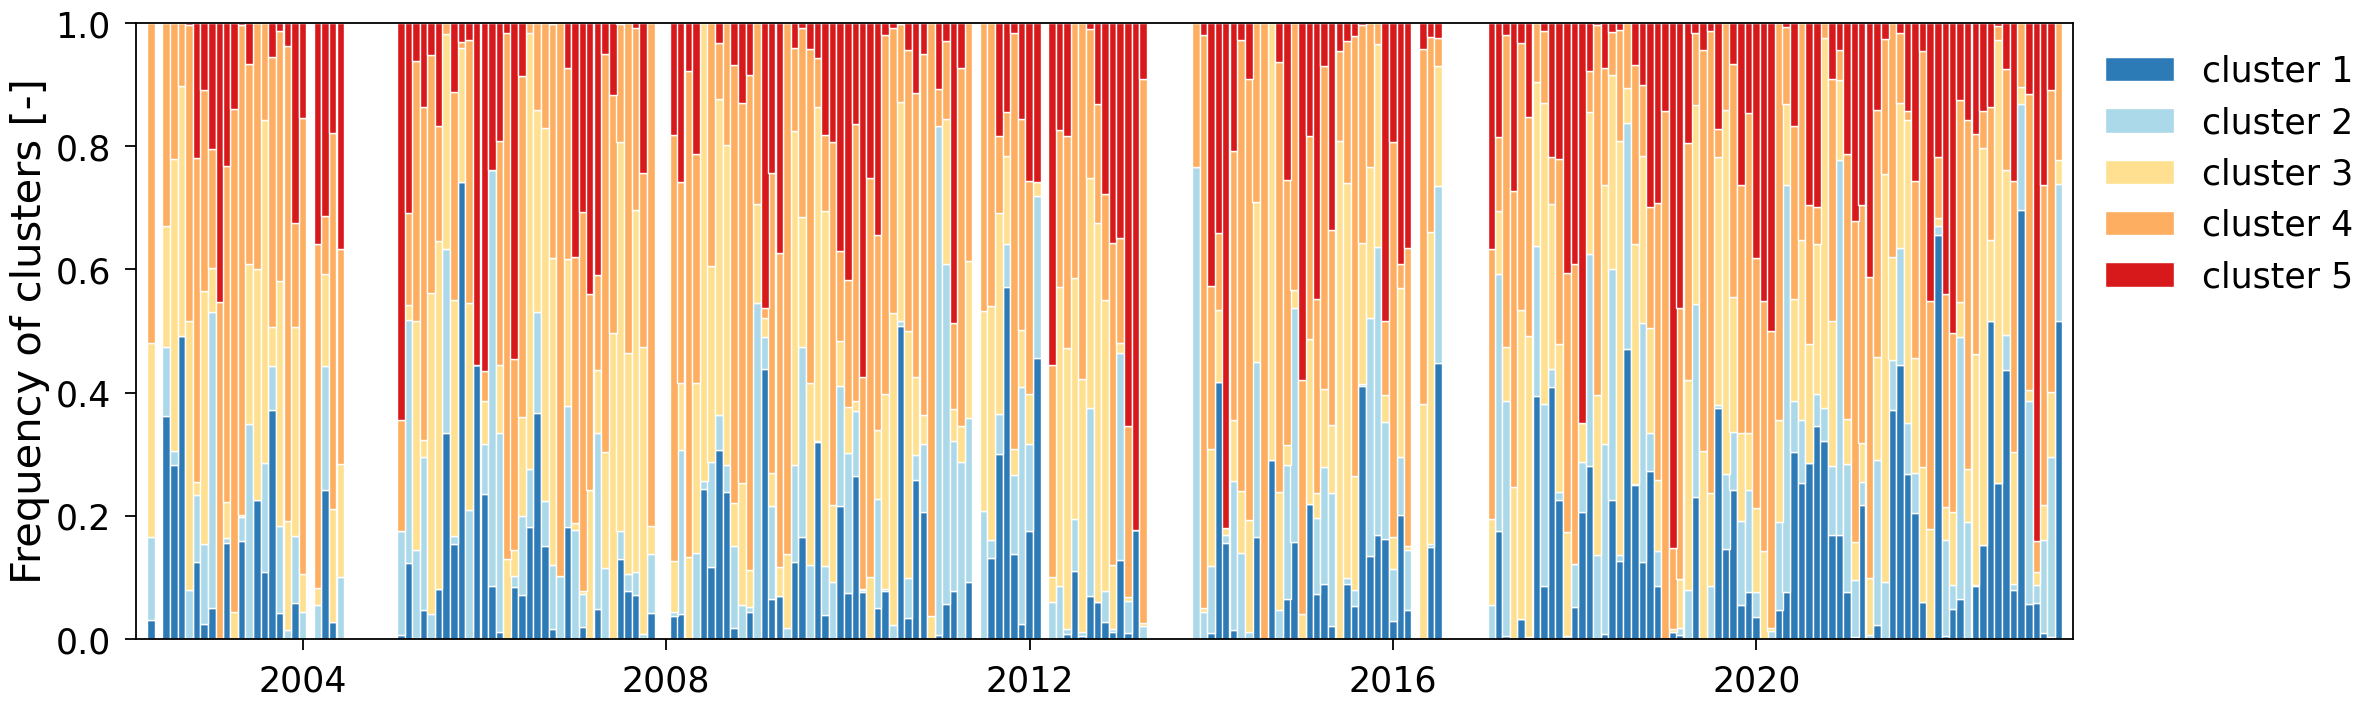

In [66]:
df_month_years_clusters = fu_cluster.month_years_clusters(df_max_count_abs637, nb_clusters=5)
month_year_ticks = fu_cluster.create_ticks_months_years(df_month_years_clusters)

fig = fu_cluster.plot_all_month_and_clusters(df_month_years_clusters, nb_clusters=5, 
                                             dict_cluster_to_colors=dict_cluster_to_colors,
                                             days_to_subtract_xlim=60)

In [67]:
df_month_years_clusters.head(2)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,month_sum,duration
2002-04-30,0.030581,0.134557,0.314985,0.519878,0.0,327.0,30
2002-05-31,0.000000,0.000000,0.000000,0.000000,0.0,0.0,31


In [70]:
df_annual_clusters.head(2)

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,month_sum,check_percentage_sum,index
month,,,,,,,,
1,0.110092,0.127189,0.080206,0.256881,0.425632,7194,1.0,1
2,0.081204,0.141736,0.071875,0.329376,0.375808,9433,1.0,2


In [71]:
clusters = np.arange(1, 6, 1)
names = ['North Atlantic', 'Greenland', 'Arctic Ocean', 'Siberia', 'Eurasia']
dict_titles = dict(zip(names, clusters))

# Figure S12: 

cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
['cluster_1_freq', 'cluster_2_freq', 'cluster_3_freq', 'cluster_4_freq', 'cluster_5_freq']
[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.96078431e-03 7.09281308e-01 9.23289106e-01 1.00000000e+00]
 [5.03921569e-01 9.99981027e-01 7.04925547e-01 1.00000000e+00]
 [1.00000000e+00 7.00543038e-01 3.78411050e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]
{1: 'J', 2: 'F', 3: 'M', 4: 'A', 5: 'M', 6: 'J', 7: 'J', 8: 'A', 9: 'S', 10: 'O', 11: 'N', 12: 'D'}


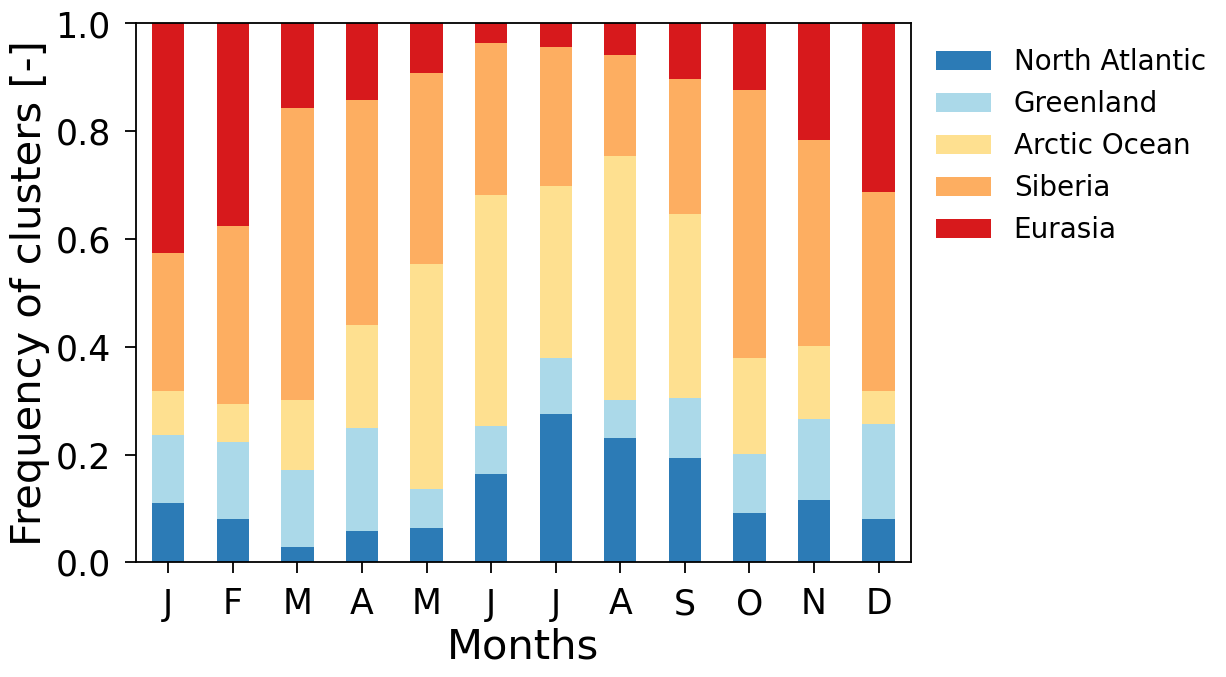

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\plots']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\FigureS12.png


In [72]:
df_annual_clusters = fu_cluster.groupby_count_clusters(df_max_count_abs637, nb_clusters=5)

fig = fu_cluster.plot_annual_clusters(df_annual_clusters, nb_clusters=5,
                                     dict_cluster_to_colors=dict_cluster_to_colors)

fu_cluster.save_plot(fig, path=savepathplots, folder='', 
                     name='FigureS12', formated=".png", dpi=300)

# Timeseries with max fractio criteria:  

## Adjusted: 

In [73]:
df_clusters = fu_trends.prepare_data(df_clusters, season_num_to_season)

start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


## max criteria used: 

In [74]:
df_max_count_abs637.head(2)

,clusters_5,count,abs637,fraction_241,tp_era5,RAINFALL,date,timestamp,ordinal,day,month,year,year_num,month_ordinal,month_num,season_abb,season_name,season_abb_year,season_ordinal
2002-03-08 14:00:00,5,0.555556,0.238,1.0,6.328704,3.969907,2002-03-08,2002-03-08 14:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,5,0.555556,0.082,1.0,6.259259,3.277778,2002-03-08,2002-03-08 15:00:00,1,8,3,2002,1,3,3,AHZ,Arctic Haze,AHZ_2002,1


In [75]:
df_max_count_abs637 = fu_trends.prepare_data(df_max_count_abs637, season_num_to_season)

start date inserted: 2002-03-08
Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 62
full_season_to_season_num given


# Trends: 

In [76]:
df_weighted_month_means_slice = fu_cluster.slice_df(df_clusters, start_datetime='2001-12-31', end_datetime=None)   

## Weighted by occurance: 

{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


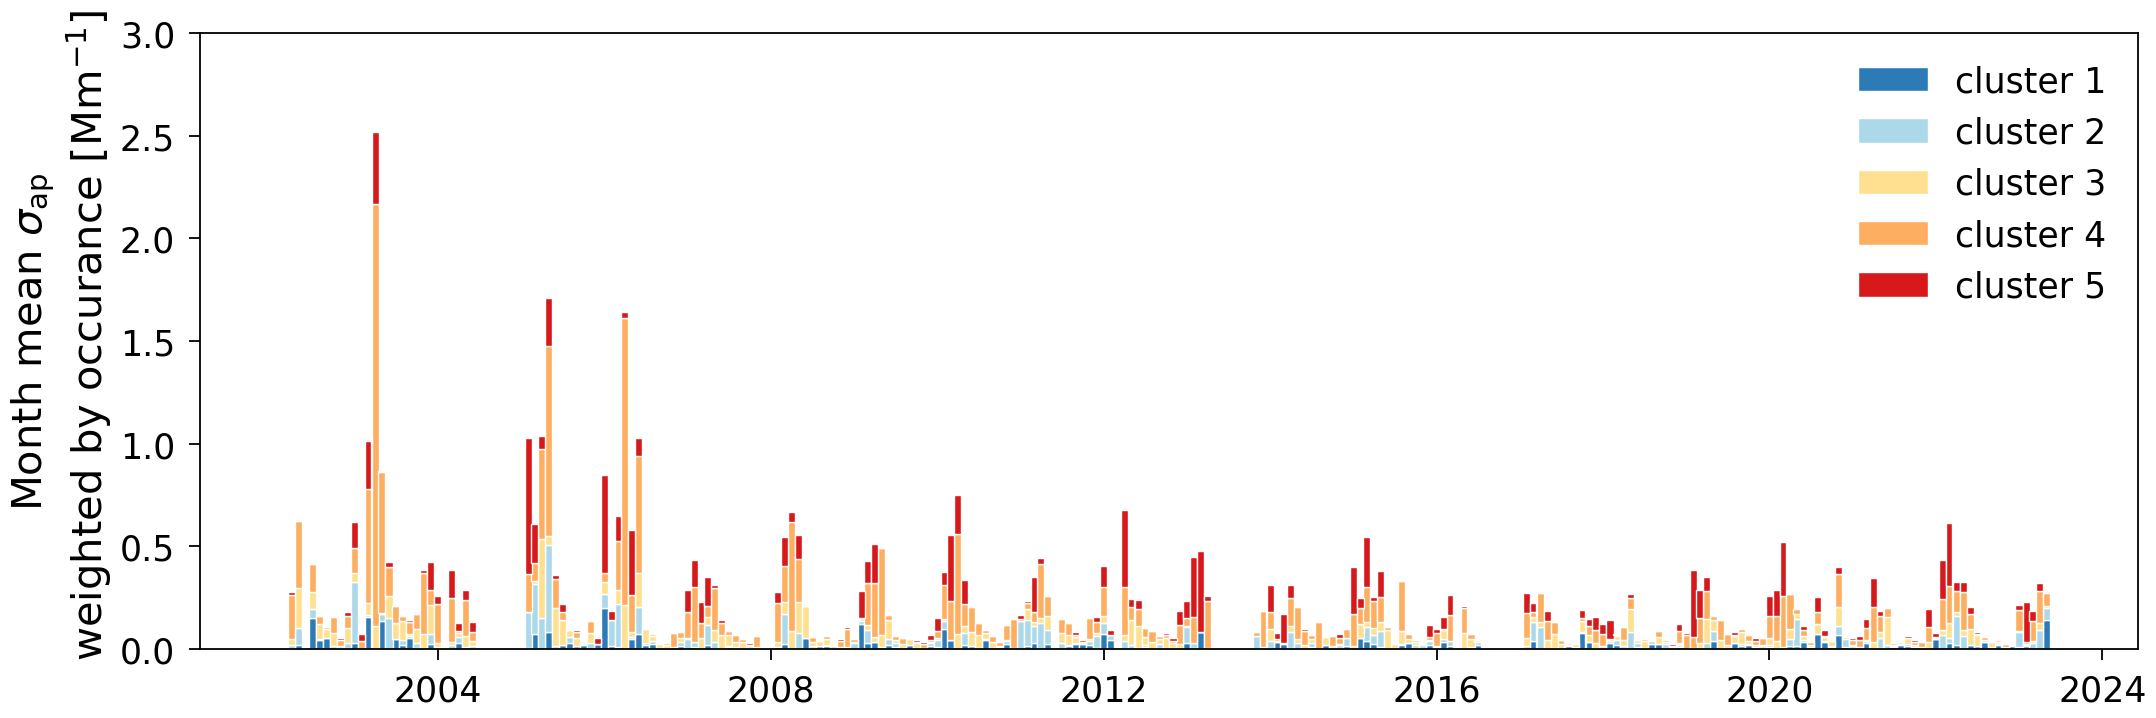

In [126]:
df_weighted_month_means = fu_cluster.monthly_mean_weighted_by_occurance(df_max_count_abs637)

fig = fu_cluster.plot_all_month_and_clusters(df_weighted_month_means, nb_clusters=5, ymax=3,
                                             ylabel='Month mean $\sigma_{\mathrm{ap}}$\n weighted by occurance [Mm$^{-1}$]',
                                             dict_cluster_to_colors=dict_cluster_to_colors)

# Seasonal trends: 

In [78]:
df_clustering_seasonal_ordinal_count = fu_cluster.groupby_count_clusters(df_max_count_abs637, nb_clusters=5, groupby_var='season_ordinal')

cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5


In [79]:
df_clustering_seasonal_ordinal_count.head(2)

,cluster_1_freq,cluster_2_freq,cluster_3_freq,cluster_4_freq,cluster_5_freq,season_ordinal_sum,check_percentage_sum
season_ordinal,,,,,,,
1,0.01250,0.098750,0.192500,0.672500,0.023750,800.0,1.0
2,0.29878,0.054201,0.371274,0.275068,0.000678,1476.0,1.0


In [80]:
def create_season_num_to_season_dict(df_max_count_abs637):
    start_year = df_max_count_abs637.index.year[0]
    print("start year: "+str(start_year))
    number_years = len(df_max_count_abs637.index.year.unique())
    print("number years: "+str(number_years))  
    first_season = fu_cluster.get_first_season(df_max_count_abs637) 
    season_to_season_num = fu_cluster.get_full_season_abb_years(start_year, number_years, first_season)
    season_num_to_season = fu_cluster.reverse_dict(season_to_season_num)
    print(season_num_to_season)
    return season_num_to_season

In [81]:
season_num_to_season = create_season_num_to_season_dict(df_max_count_abs637)

start year: 2002
number years: 22
{1: 'AHZ_2002', 2: 'SUM_2002', 3: 'SBU_2002', 4: 'AHZ_2003', 5: 'SUM_2003', 6: 'SBU_2003', 7: 'AHZ_2004', 8: 'SUM_2004', 9: 'SBU_2004', 10: 'AHZ_2005', 11: 'SUM_2005', 12: 'SBU_2005', 13: 'AHZ_2006', 14: 'SUM_2006', 15: 'SBU_2006', 16: 'AHZ_2007', 17: 'SUM_2007', 18: 'SBU_2007', 19: 'AHZ_2008', 20: 'SUM_2008', 21: 'SBU_2008', 22: 'AHZ_2009', 23: 'SUM_2009', 24: 'SBU_2009', 25: 'AHZ_2010', 26: 'SUM_2010', 27: 'SBU_2010', 28: 'AHZ_2011', 29: 'SUM_2011', 30: 'SBU_2011', 31: 'AHZ_2012', 32: 'SUM_2012', 33: 'SBU_2012', 34: 'AHZ_2013', 35: 'SUM_2013', 36: 'SBU_2013', 37: 'AHZ_2014', 38: 'SUM_2014', 39: 'SBU_2014', 40: 'AHZ_2015', 41: 'SUM_2015', 42: 'SBU_2015', 43: 'AHZ_2016', 44: 'SUM_2016', 45: 'SBU_2016', 46: 'AHZ_2017', 47: 'SUM_2017', 48: 'SBU_2017', 49: 'AHZ_2018', 50: 'SUM_2018', 51: 'SBU_2018', 52: 'AHZ_2019', 53: 'SUM_2019', 54: 'SBU_2019', 55: 'AHZ_2020', 56: 'SUM_2020', 57: 'SBU_2020', 58: 'AHZ_2021', 59: 'SUM_2021', 60: 'SBU_2021', 61: 'AHZ_2022'

In [82]:
df_seasonal_averages = fu_cluster.seasonal_averages(df_max_count_abs637, 
                                                    variable='abs637',
                                                    season_num_to_season=season_num_to_season)

In [83]:
df_seasonal_averages.head(2)

,mean,median,min,max,std,count,q25,q75,season_abb_year,start,stop,mid_datetime,season_abb
season_ordinal,,,,,,,,,,,,,
1,0.417650,0.2705,0.0,3.140,0.428555,800,0.133,0.55225,AHZ_2002,2002-02-01,2002-05-31,2002-04-01 12:00:00,AHZ
2,0.218518,0.1030,0.0,2.176,0.289610,1476,0.048,0.24450,SUM_2002,2002-06-01,2002-09-30,2002-07-31 12:00:00,SUM


In [84]:
def add_mid_datetime(df_clustering_seasonal_ordinal_count, df_seasonal_averages):
    dict_season_ordinal_to_mid_datetime = dict(zip(df_seasonal_averages.index, df_seasonal_averages['mid_datetime']))
    dict_season_ordinal_to_season_abb = dict(zip(df_seasonal_averages.index, df_seasonal_averages['season_abb']))

    df_clustering_seasonal_ordinal_count['mid_datetime'] = df_clustering_seasonal_ordinal_count.index.map(dict_season_ordinal_to_mid_datetime)
    df_clustering_seasonal_ordinal_count['season_abb'] = df_clustering_seasonal_ordinal_count.index.map(dict_season_ordinal_to_season_abb)
    return df_clustering_seasonal_ordinal_count

In [85]:
df_clustering_seasonal_ordinal_count = add_mid_datetime(df_clustering_seasonal_ordinal_count, df_seasonal_averages)

['cluster_1_freq', 'cluster_2_freq', 'cluster_3_freq', 'cluster_4_freq', 'cluster_5_freq']
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


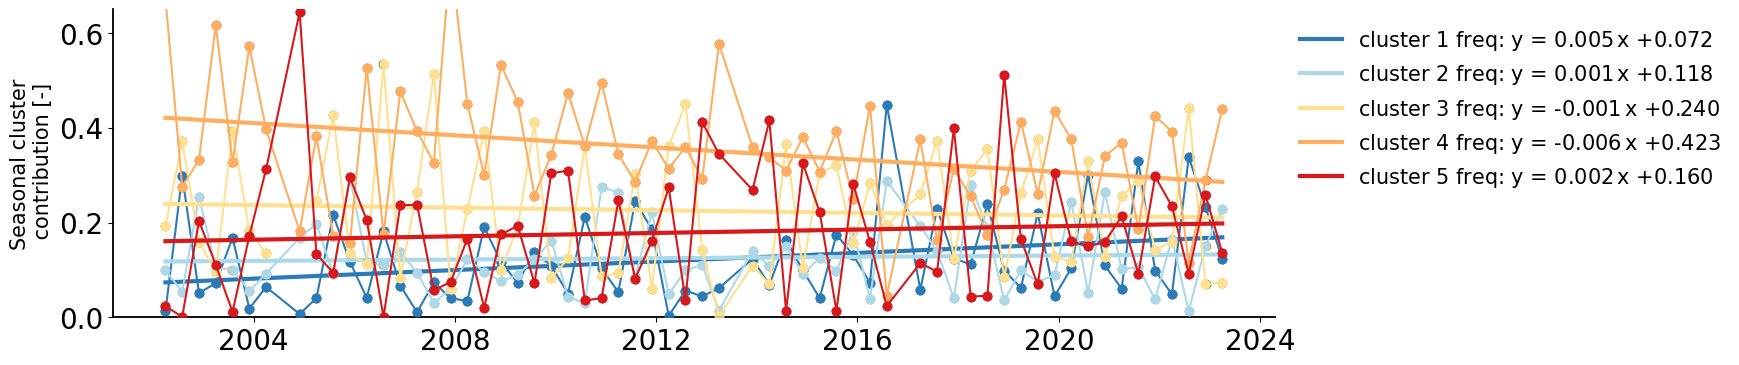

In [87]:
fig = fu_cluster.trend_cluster(df_clustering_seasonal_ordinal_count, ncol=1,
                               ylabel='Seasonal cluster\n contribution [-]', dict_cluster_to_colors=dict_cluster_to_colors)

Season: AHZ
['cluster_1_freq', 'cluster_2_freq', 'cluster_3_freq', 'cluster_4_freq', 'cluster_5_freq']
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


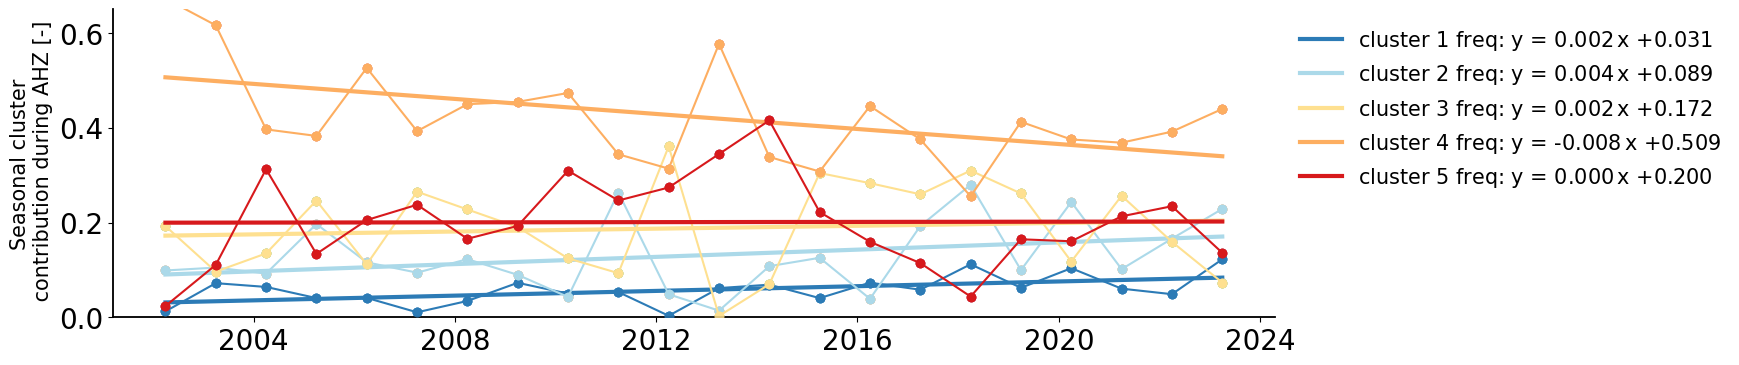

Season: SUM
['cluster_1_freq', 'cluster_2_freq', 'cluster_3_freq', 'cluster_4_freq', 'cluster_5_freq']
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


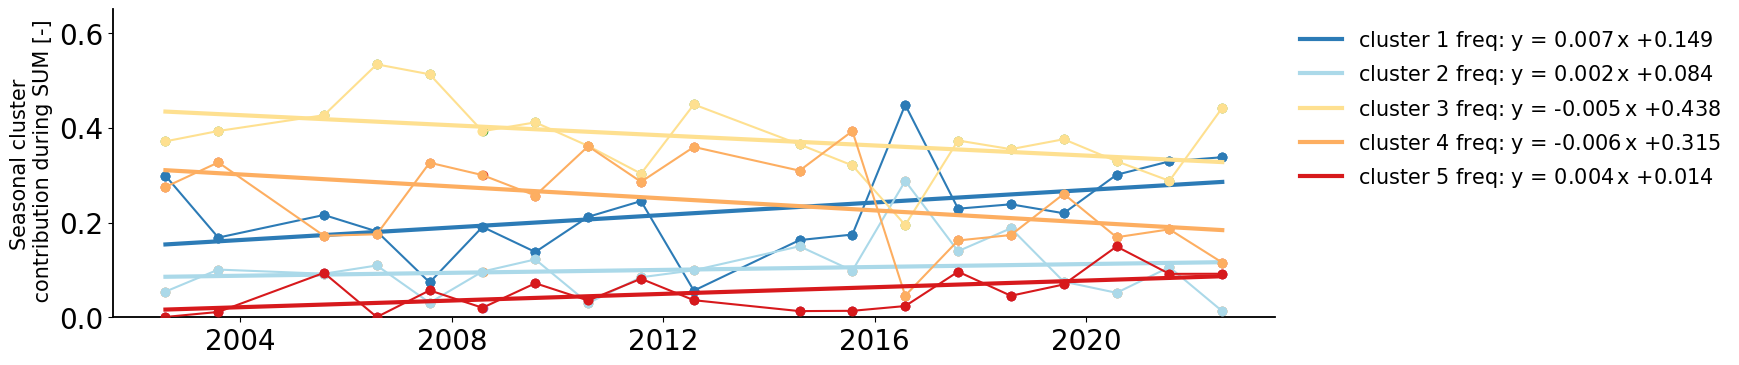

Season: SBU
['cluster_1_freq', 'cluster_2_freq', 'cluster_3_freq', 'cluster_4_freq', 'cluster_5_freq']
{1: '#2c7bb6', 2: '#abd9e9', 3: '#fee090', 4: '#fdae61', 5: '#d7191c'}


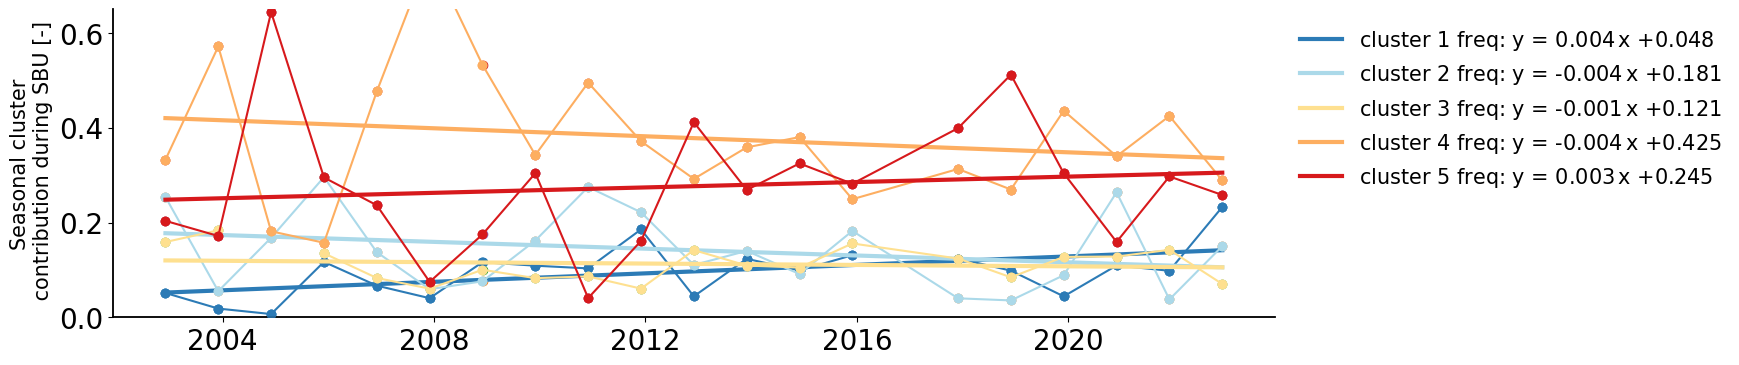

In [88]:
for season in ['AHZ', 'SUM','SBU']:
    print("Season: "+str(season))
    df_season = df_clustering_seasonal_ordinal_count[df_clustering_seasonal_ordinal_count['season_abb'] == season]
    fig = fu_cluster.trend_cluster(df_season, ncol=1,
                               ylabel='Seasonal cluster\n contribution during '+str(season)+' [-]', 
                                  dict_cluster_to_colors=dict_cluster_to_colors)

# Frequency vs. source reductions: 

In [89]:
df_abs_year_mean_for_clusters = fu_cluster.create_df_abs_year_mean_clusters(df_max_count_abs637,) #annual mean of each cluster and total
df_year_freq_for_clusters = fu_cluster.groupby_count_clusters(df_max_count_abs637, nb_clusters=5, groupby_var='year')
df_year_freq_for_clusters_weighted = fu_cluster.calculate_weighted_means(df_year_freq_for_clusters, df_max_count_abs637,)
dict_first_3_years = fu_cluster.get_first_3_years(df_abs_year_mean_for_clusters)
df_year_freq_for_clusters_weighted = fu_cluster.calculate_weight_fixed(df_year_freq_for_clusters_weighted, dict_first_3_years)

cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
      cluster_1_freq  cluster_2_freq  cluster_3_freq  cluster_4_freq  \
year                                                                   
2002        0.152724        0.138732        0.266151        0.380173   
2003        0.085288        0.085676        0.217872        0.506106   
2004        0.064037        0.092213        0.134734        0.396516   
2005        0.109765        0.150578        0.272083        0.269474   
2006        0.102624        0.170068        0.254033        0.338776   
2007        0.041037        0.064009        0.324956        0.425879   
2008        0.087050        0.096831        0.252347        0.464202   
2009        0.123364        0.120374        0.240000        0.320000   
2010        0.130564        0.071429        0.184824        0.463756   
2011        0.143489        0.203354        0.177265        0.339856   
2012        0.069486        0.105143        0.319771        0.303086   
2013     

In [90]:
dict_cluster_to_name = {1:'NA', 2:'G', 3:'AO', 4:'S', 5:'E'}

# Figure 4:

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


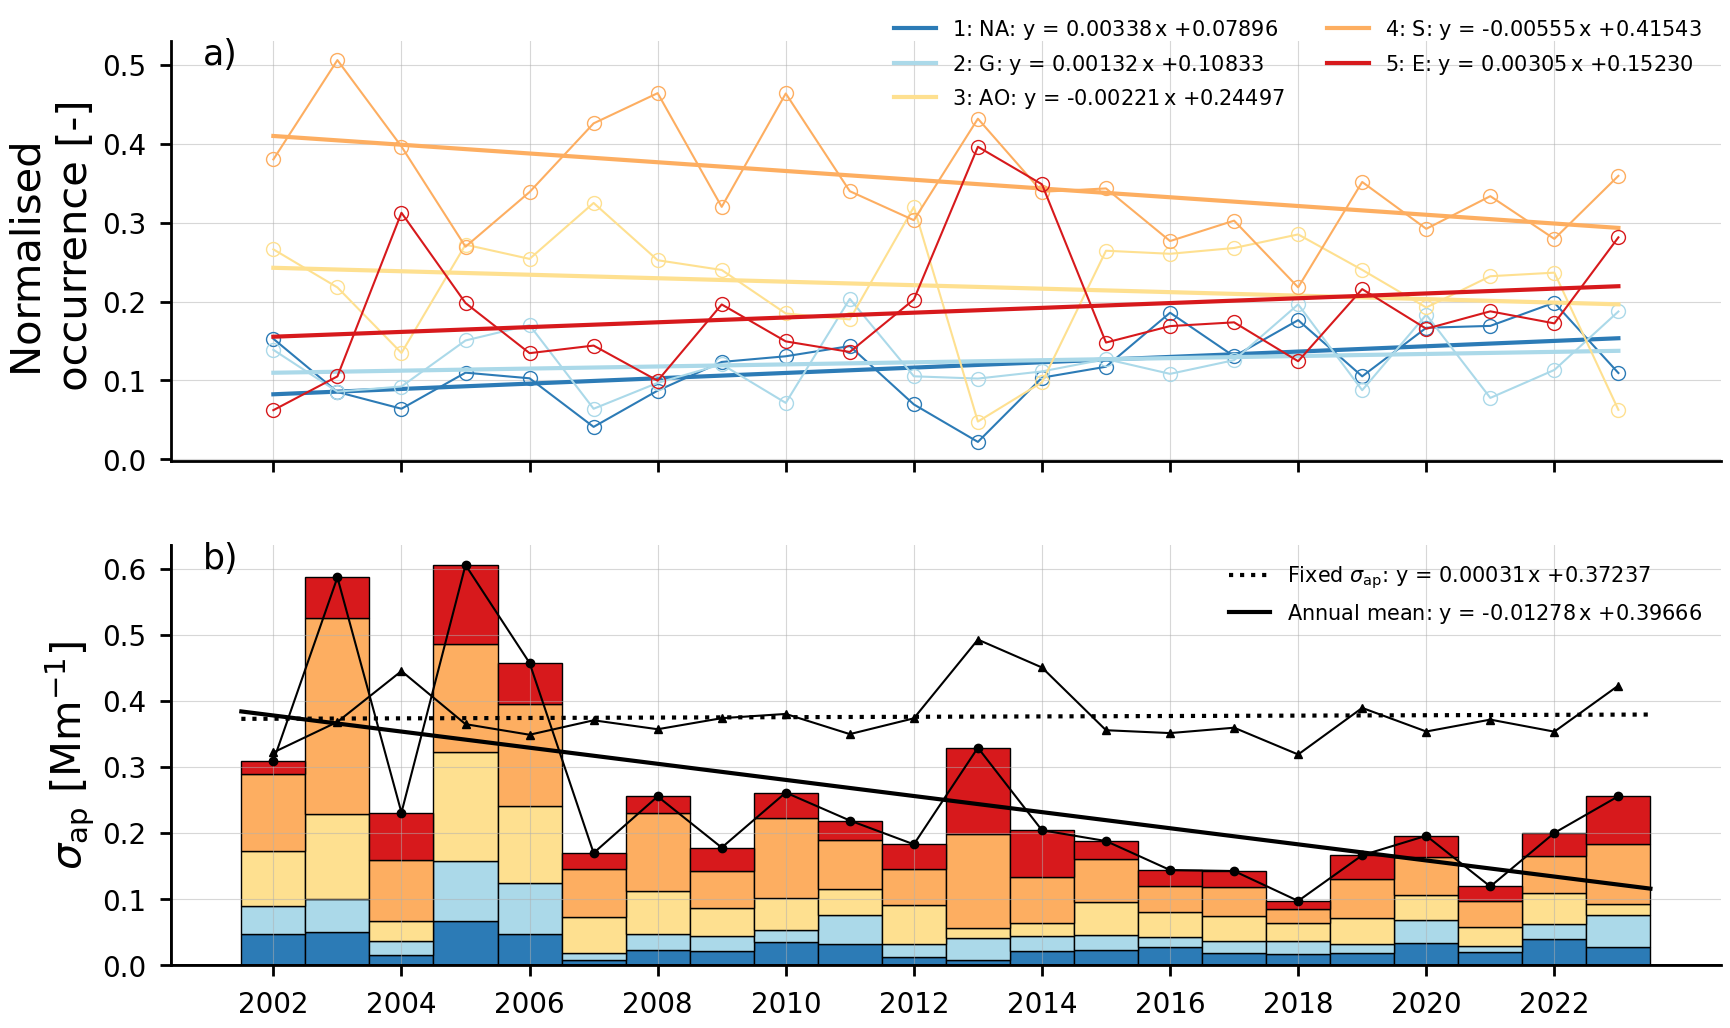

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\plots']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\plots\\Figure4.png


In [91]:
fig = fu_cluster.weighted_fixed_trend_subplots(df_year_freq_for_clusters_weighted, dict_cluster_to_colors=dict_cluster_to_colors,
                                               dict_cluster_to_name=dict_cluster_to_name, dp=5,)
fu_cluster.save_plot(fig, path=savepathplots, folder='',
              name='Figure4', formated=".png", dpi=300)

# Save final timeseries: 

In [ ]:
fu_trends.save_df(df_max_count_abs637, 
                  r'C:\Users\DominicHeslinRees\Documents\Analysis\Clustering\timeseries',
                 name='cluster_timeseries')

# Compare to raw data: 

Basically, here, we load a bunch of back trajectories we then run the clustering to see if it looks resonably similar. 

In [99]:
sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\HYSPLIT_plotting')

import HYSPLIT_plotting as HYplot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Matching files from observational data & HYSPLIT: 81
file: F:\HYSPLIT\processed\2002\20020308_14.pickle
file: F:\HYSPLIT\processed\2002\20020308_15.pickle
file: F:\HYSPLIT\processed\2002\20020308_16.pickle
file: F:\HYSPLIT\processed\2002\20020308_17.pickle
file: F:\HYSPLIT\processed\2002\20020308_18.pickle
file: F:\HYSPLIT\processed\2002\20020308_19.pickle
file: F:\HYSPLIT\processed\2002\20020308_20.pickle
file: F:\HYSPLIT\processed\2002\20020308_21.pickle
file: F:\HYSPLIT\processed\2002\20020308_22.pickle
file: F:\HYSPLIT\processed\2002\20020308_23.pickle
file: F:\HYSPLIT\processed\2002\20020309_00.pickle
file: F:\HYSPLIT\processed\2002\20020309_01.pickle
file: F:\HYSPLIT\processed\2002\20020309_02.pickle
file: F:\HYSPLIT\processed\2002\20020309_03.pickle
file: F:\HYSPLIT\processed\2002\20020309_04.pickle
file: F:\HYSPLIT\processed\2002\20020309_05.pickle
file: F:\HYSPLIT\processed\2002\20020309_06.pickle
file: F:\HYSPLIT\processed\2002\20020309_07.pickle
file: F:\HYSPLIT\processed\20

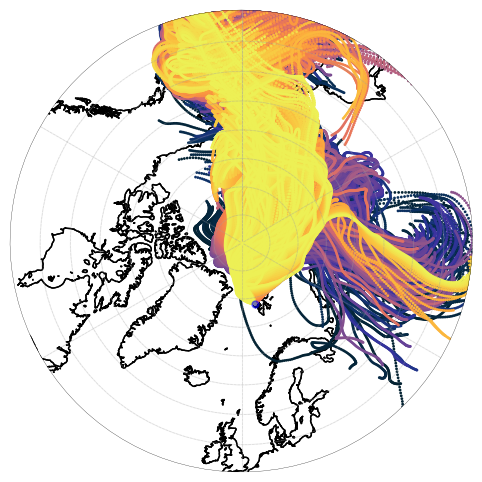

In [101]:
time_range = list(pd.date_range('2002-03-08 14:00:00', '2002-03-11 22:00:00', freq='H')) #using time range
HYSPLIT_names_obs = HYplot.create_HYSPLIT_name_from_list(time_range) #for whole period

#list all the preprocessed HYSPLIT files - ones actually have preprocessed
list_of_HYSPLIT_files = HYplot.list_files(year=2002, 
                                          inpath_processed_hysplit_dfs="F:\\HYSPLIT\\processed\\")

#match the files with the datetimes interested
matching_list_of_back_traj_files = HYplot.find_matching_files(list_of_HYSPLIT_files, HYSPLIT_names_obs)

#read in the matching files 
trajs_dictionary = HYplot.create_traj_dictionary_using_matching_files(matching_list_of_back_traj_files, 
                                                                      select_for_mixed_layer=False)

fig = HYplot.circular_traj_plots(trajs_dictionary)

In [120]:
def random_comparsions(time_range,
                      inpath = None,
                      inpath_processed_hysplit_dfs="F:\\HYSPLIT\\processed\\",
                      year=2002,
                      save_fig_path=r'C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\cluster_examples'):
    
    #convert the datetimes to HYSPLIT names
    HYSPLIT_names_obs = HYplot.create_HYSPLIT_name_from_list(time_range) #for whole period
    #list all the preprocessed HYSPLIT files - ones actually have preprocessed
    list_of_HYSPLIT_files = HYplot.list_files(year=year, 
                                              inpath_processed_hysplit_dfs=inpath_processed_hysplit_dfs)
    #match the files with the datetimes interested
    matching_list_of_back_traj_files = HYplot.find_matching_files(list_of_HYSPLIT_files, HYSPLIT_names_obs)
    
    if len(matching_list_of_back_traj_files) > 1: #read in the matching files 
        trajs_dictionary = HYplot.create_traj_dictionary_using_matching_files(matching_list_of_back_traj_files, 
                                                                              select_for_mixed_layer=False)

        title=str(time_range[0])+' - '+str(time_range[-1])
        fig = HYplot.circular_traj_plots(trajs_dictionary, title=title)
        
        save_title = title.replace('-','')
        save_title = save_title.replace(':','')
        save_title = save_title.replace(' ','_')
        
        fu_cluster.save_plot(fig, path=save_fig_path, name=str(save_title)) 
        
        df_clustering_example = fu_cluster.read_in_or_process(read_in=False, process=True, clustering=True, 
                                                      lat_lon_alt=False, number_to_process=None, inpath=inpath,
                                                      list_of_all_files=matching_list_of_back_traj_files,
                                                      data_format='.pickle')
        
        df_clustering_example = fu_cluster.clustering(df_clustering_example, mini_batch=False, just_clusters=False)
        df_value_count_example = fu_cluster.count_value_find_percentage(df_clustering_example)
        df_max_count_example = fu_cluster.find_the_max_count(df_value_count_example)
        df_max_count_example = fu_cluster.merge_with_obs(df_abs637_rain, df_max_count_example)
        df_percentage_clusters_example = fu_cluster.calculate_percentage_of_clusters_and_averages(df_max_count_example, 
                                                                             nb_clusters=5, var='abs637')
        dict_var_to_df_values_example = {'abs637':df_percentage_clusters_example}
        dict_cluster_to_df_mean_example = fu_cluster.create_dict_cluster_to_df_average(df_clustering_example, nb_clusters=5)

        fig = fu_cluster.circular_plots(5, dict_cluster_to_df_mean_example, 
                                        df_values=dict_var_to_df_values_example['abs637'],
                                        title="Cluster: $\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]",
                                        dict_cluster_to_colors=dict_cluster_to_colors,
                                        scatter_projection='PlateCarree')
        
        fu_cluster.save_plot(fig, path=save_fig_path, name=str(save_title)+'_clusters')

In [121]:
def time_range_by_month(month, start='2002-03-08 14:00:00', stop='2002-03-11 22:00:00'):    
    stop = pd.to_datetime(stop)
    start = pd.to_datetime(start)
    start = start + relativedelta(months=month) #add month
    stop = stop + relativedelta(months=month)
    print(start)
    print(stop)
    time_range = list(pd.date_range(start, stop, freq='H')) #using time range
    return time_range

1
2012-04-08 14:00:00
2012-04-10 14:00:00
Matching files from observational data & HYSPLIT: 49
file: F:\HYSPLIT\processed\2012\20120408_14.pickle
file: F:\HYSPLIT\processed\2012\20120408_15.pickle
file: F:\HYSPLIT\processed\2012\20120408_16.pickle
file: F:\HYSPLIT\processed\2012\20120408_17.pickle
file: F:\HYSPLIT\processed\2012\20120408_18.pickle
file: F:\HYSPLIT\processed\2012\20120408_19.pickle
file: F:\HYSPLIT\processed\2012\20120408_20.pickle
file: F:\HYSPLIT\processed\2012\20120408_21.pickle
file: F:\HYSPLIT\processed\2012\20120408_22.pickle
file: F:\HYSPLIT\processed\2012\20120408_23.pickle
file: F:\HYSPLIT\processed\2012\20120409_00.pickle
file: F:\HYSPLIT\processed\2012\20120409_01.pickle
file: F:\HYSPLIT\processed\2012\20120409_02.pickle
file: F:\HYSPLIT\processed\2012\20120409_03.pickle
file: F:\HYSPLIT\processed\2012\20120409_04.pickle
file: F:\HYSPLIT\processed\2012\20120409_05.pickle
file: F:\HYSPLIT\processed\2012\20120409_06.pickle
file: F:\HYSPLIT\processed\2012\201204

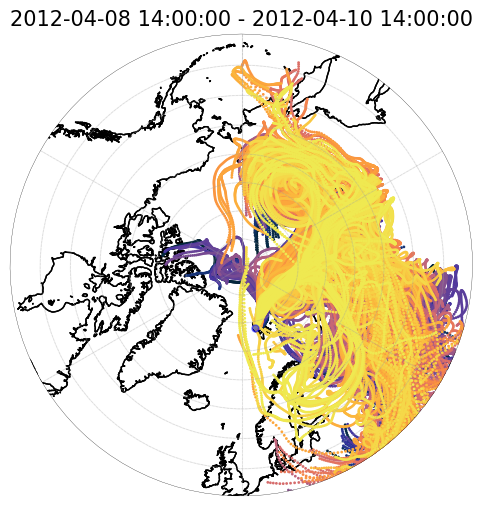

['C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\final_plots\\cluster_examples']
make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\cluster_examples\\20120408_140000__20120410_140000.jpeg
for clustering file
processing:
get a df ready for clustering: 
no file given: start from zero analysed
file: F:\HYSPLIT\processed\2012\20120408_14.pickle
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of grid space
arrival time: 2012-04-08 14:00:00
no rotation of gri

no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 2012-04-08 19:00:00
no rotation of grid space
arrival time: 

arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rotation of grid space
arrival time: 2012-04-09 00:00:00
no rot

arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
no rotation of grid space
arrival time: 2012-04-09 05:00:00
file: 

no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 2012-04-09 10:00:00
no rotation of grid space
arrival time: 

arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
no rotation of grid space
arrival time: 2012-04-09 15:00:00
file: F:\HYSPLIT\processed\2012\20120409_16.pickle
no rotation of grid space
arrival time: 2012-04-09 16:00:00
no rotation of grid space
arrival time: 2012-04-09 16:00:00
no rotation of grid space
arrival time: 2012-04-09 16:00:00
no rotation of 

arrival time: 2012-04-09 20:00:00
no rotation of grid space
arrival time: 2012-04-09 20:00:00
no rotation of grid space
arrival time: 2012-04-09 20:00:00
no rotation of grid space
arrival time: 2012-04-09 20:00:00
no rotation of grid space
arrival time: 2012-04-09 20:00:00
no rotation of grid space
arrival time: 2012-04-09 20:00:00
file: F:\HYSPLIT\processed\2012\20120409_21.pickle
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of grid space
arrival time: 2012-04-09 21:00:00
no rotation of 

no rotation of grid space
arrival time: 2012-04-10 01:00:00
no rotation of grid space
arrival time: 2012-04-10 01:00:00
no rotation of grid space
arrival time: 2012-04-10 01:00:00
no rotation of grid space
arrival time: 2012-04-10 01:00:00
no rotation of grid space
arrival time: 2012-04-10 01:00:00
file: F:\HYSPLIT\processed\2012\20120410_02.pickle
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-10 02:00:00
no rotation of grid space
arrival time: 2012-04-1

arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rotation of grid space
arrival time: 2012-04-10 07:00:00
no rot

arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
no rotation of grid space
arrival time: 2012-04-10 12:00:00
file: F:\HYSPLIT\processed\2012\20120410_13.pickle
no rotation of 

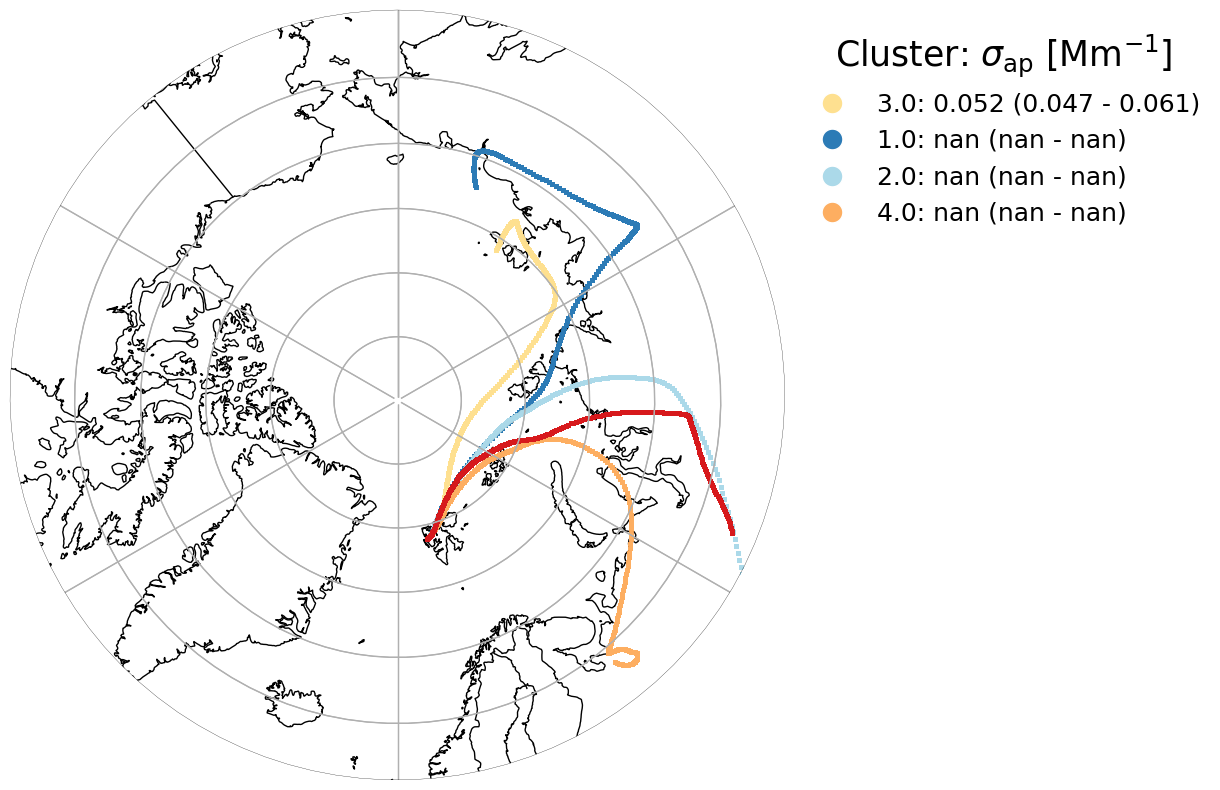

['C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\final_plots\\cluster_examples']
make folder
saved as: C:\Users\DominicHeslinRees\Pictures\black_carbon\final_plots\cluster_examples\\20120408_140000__20120410_140000_clusters.jpeg


In [122]:
year = 2012
for month in np.arange(1, 2, 1): #for number of months to do this 'random' comparsion
    print(month)
    time_range = time_range_by_month(month, 
                                     start=str(year)+'-03-08 14:00:00', 
                                     stop=str(year)+'-03-10 14:00:00' )
    random_comparsions(time_range,
                      inpath = "C:\\Users\\DominicHeslinRees\\Documents\\Analysis\\Clustering\\",
                      inpath_processed_hysplit_dfs="F:\\HYSPLIT\\processed\\",
                      year=year)